# Project 6 EDA Notebook: All-time NBA Scoring Leaders
**Author:** Bin Ware

**Date:** 10/04/2024

**Purpose:** This dataset contains information on all-time NBA scoring leaders, sourced from Statista. It includes data such as player names, total career points, and ranking among top NBA scorers. The dataset will be used to explore trends in scoring, visualize player performance, and identify key insights about scoring leaders throughout NBA history.


In [450]:
# Import necessary libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [451]:
# Set Seaborn style for better aesthetics
sns.set(style="whitegrid")

# List of players and their URLs on Basketball Reference
players = {
    "LeBron James": "https://www.basketball-reference.com/players/j/jamesle01.html",
    "Kareem Abdul-Jabbar": "https://www.basketball-reference.com/players/a/abdulka01.html",
    "Karl Malone": "https://www.basketball-reference.com/players/m/malonka01.html"
}

# Dictionary to store dataframes for each player
players_data = {}

# Headers for web requests to simulate a real browser
request_headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

# Load the original dataset from Excel
original_df = pd.read_excel("data/nba-all-time-scoring-list-1946-2024.xlsx", sheet_name='Data', skiprows=4)

# Clean and rename columns for better usability
original_df.columns = ['Rank', 'Player', 'Total_Points']
original_df = original_df[['Player', 'Total_Points']].dropna().reset_index(drop=True)

In [452]:
# Display initial DataFrame for verification
print("Original Dataset (Top 5 Rows):")
print(original_df.head())

Original Dataset (Top 5 Rows):
                Player  Total_Points
0       LeBron James *         40474
1  Kareem Abdul-Jabbar         38387
2          Karl Malone         36928
3          Kobe Bryant         33643
4       Michael Jordan         32292


In [453]:
# Descriptive Statistics for Total Points Scored
print("\nDescriptive Statistics for Total Points Scored:")
print(original_df['Total_Points'].describe())


Descriptive Statistics for Total Points Scored:
count       30.000000
mean     28164.600000
std       4337.194999
min      23668.000000
25%      25362.500000
50%      26582.000000
75%      28842.000000
max      40474.000000
Name: Total_Points, dtype: float64


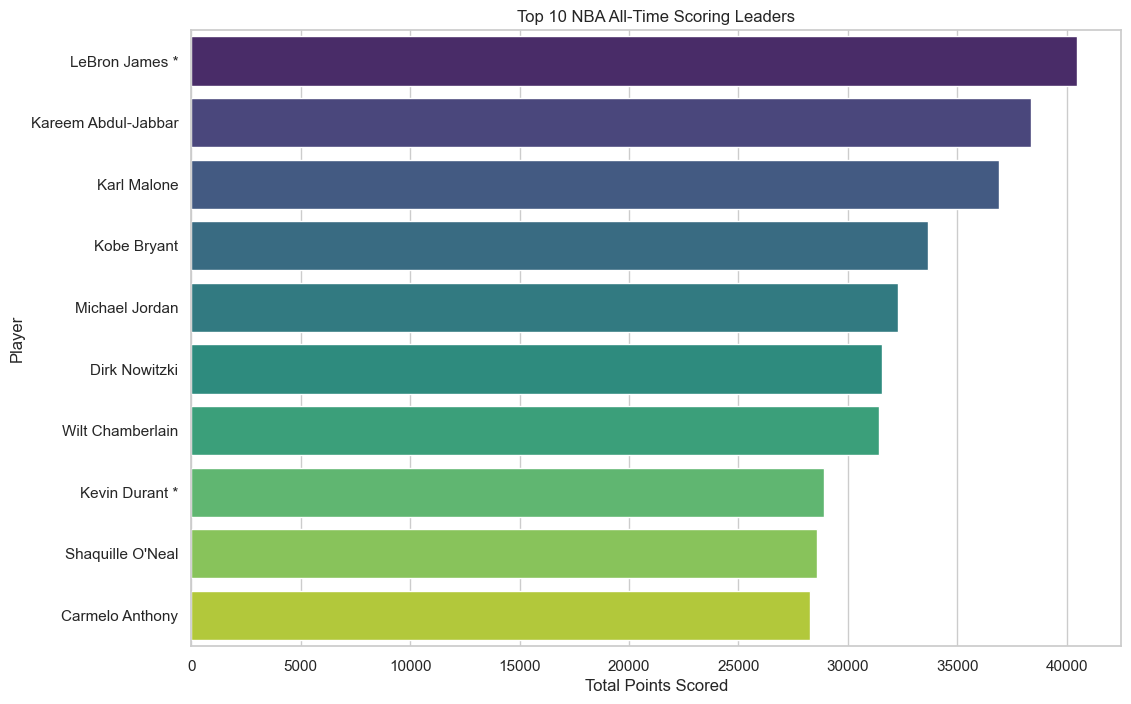

In [454]:
# Top 10 Scoring Leaders Bar Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Total_Points', y='Player', hue='Player', dodge=False, data=top_10, palette='viridis', legend=False)
plt.title('Top 10 NBA All-Time Scoring Leaders')
plt.xlabel('Total Points Scored')
plt.ylabel('Player')
plt.show()


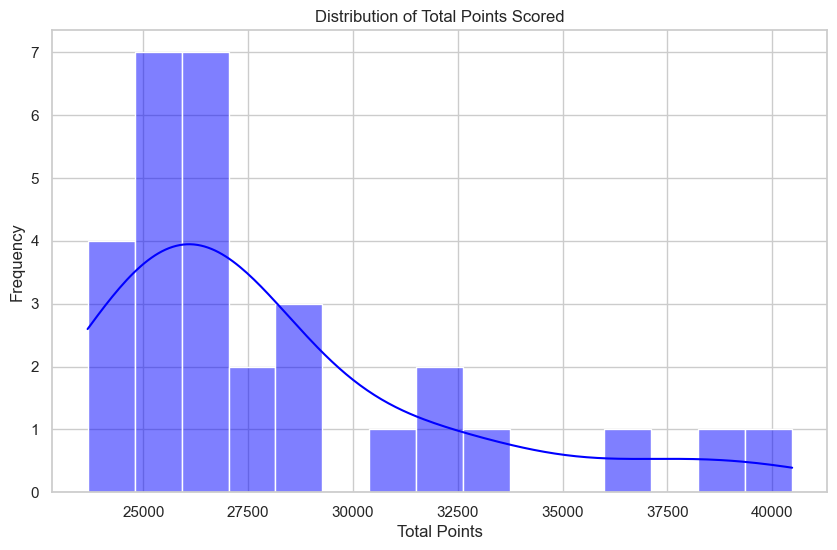

In [455]:
# Distribution Plot for Total Points Scored
plt.figure(figsize=(10, 6))
sns.histplot(original_df['Total_Points'], bins=15, kde=True, color='blue')
plt.title('Distribution of Total Points Scored')
plt.xlabel('Total Points')
plt.ylabel('Frequency')
plt.show()

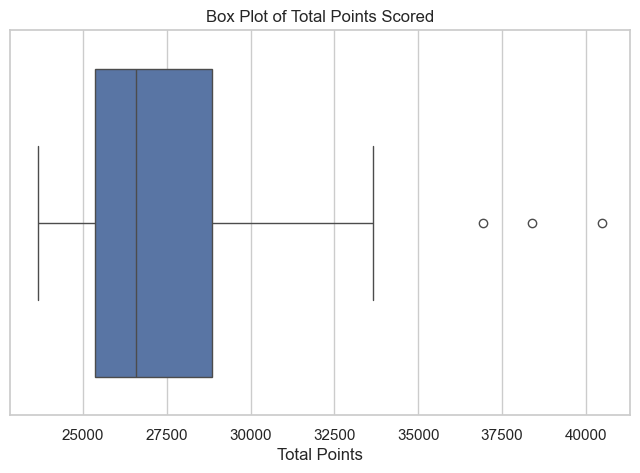

In [456]:
# Box Plot for Total Points Scored
plt.figure(figsize=(8, 5))
sns.boxplot(x='Total_Points', data=original_df)
plt.title('Box Plot of Total Points Scored')
plt.xlabel('Total Points')
plt.show()

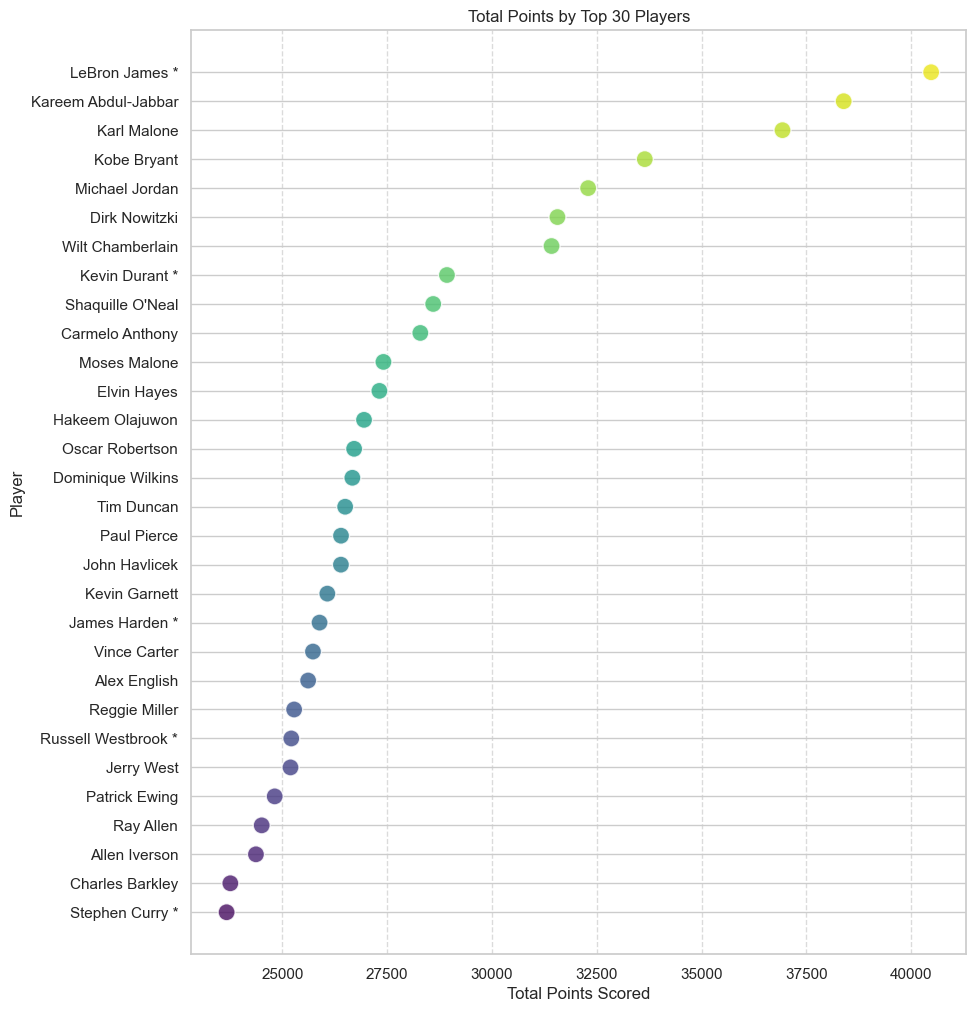

In [457]:
# Dot Plot for Top 30 Players
plt.figure(figsize=(10, 12))
palette = sns.color_palette("viridis", n_colors=len(top_30))
sns.scatterplot(x='Total_Points', y='Player', data=top_30, hue=top_30['Total_Points'], palette=palette, s=150, alpha=0.8, legend=False)

plt.title('Total Points by Top 30 Players')
plt.xlabel('Total Points Scored')
plt.ylabel('Player')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [458]:
# Loop through each player and scrape their stats
for player, url in players.items():
    response = requests.get(url, headers=request_headers)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Extract the per-game statistics table
    stats_table = soup.find('table', id='per_game')
    if stats_table:
        # Extract headers from the table
        header_tags = stats_table.find('thead').find_all('th')
        table_headers = [header.text for header in header_tags]

        # Extract valid rows (excluding header rows)
        rows = stats_table.find('tbody').find_all('tr')
        data = []
        for row in rows:
            # Skip empty rows or those without valid data
            cells = row.find_all(['th', 'td'])
            row_data = [cell.text.strip() for cell in cells]
            if len(row_data) == len(table_headers):
                data.append(row_data)

        # Convert to DataFrame and clean
        try:
            df_stats = pd.DataFrame(data, columns=table_headers)
            if 'Season' in df_stats.columns:
                # Filter rows that match the season format (e.g., '2003-04')
                df_stats = df_stats[df_stats['Season'].str.match(r'\d{4}-\d{2}', na=False)]
                # Convert the necessary columns to numeric for analysis
                df_stats['PTS'] = pd.to_numeric(df_stats['PTS'], errors='coerce')
                df_stats['AST'] = pd.to_numeric(df_stats['AST'], errors='coerce')
                df_stats['TRB'] = pd.to_numeric(df_stats['TRB'], errors='coerce')
                df_stats['FG%'] = pd.to_numeric(df_stats['FG%'], errors='coerce')

                # Store the dataframe
                players_data[player] = df_stats
        except ValueError as ve:
            print(f"ValueError occurred for {player}: {ve}")
    else:
        print(f"Statistics table not found for {player}.")


In [459]:
# Extract key metrics for comparison - Points per game, Assists, Rebounds, FG%
comparison_data = []

for player, df in players_data.items():
    # Filter out rows where Season is not a valid year range (e.g., skip summary rows)
    valid_rows = df[df['Season'].str.match(r'\d{4}-\d{2}', na=False)]
    
    # Calculate mean values for each relevant stat
    career_stats = valid_rows.mean(numeric_only=True)

    # Append to comparison data
    comparison_data.append({
        'Player': player,
        'Average Points per Game': career_stats['PTS'],
        'Average Assists per Game': career_stats['AST'],
        'Average Rebounds per Game': career_stats['TRB'],
        'Field Goal Percentage (%)': career_stats['FG%']
    })

# Create a DataFrame for comparison
df_comparison = pd.DataFrame(comparison_data)

# Display the comparison DataFrame
print("\nComparison of Key Statistics:")
print(df_comparison)


Comparison of Key Statistics:
                Player  Average Points per Game  Average Assists per Game  \
0         LeBron James                27.128571                  7.385714   
1  Kareem Abdul-Jabbar                24.590000                  3.625000   
2          Karl Malone                24.689474                  3.584211   

   Average Rebounds per Game  Field Goal Percentage (%)  
0                   7.528571                   0.508190  
1                  11.170000                   0.558350  
2                  10.089474                   0.512895  


In [460]:
# Create a DataFrame for selected players
selected_players = ['LeBron James', 'Kareem Abdul-Jabbar', 'Karl Malone']
data = {
    'Player': selected_players,
    'Career_Points': [40474, 38387, 36928]
}
selected_df = pd.DataFrame(data)

# Merging the original dataset with scraped statistics
merged_df = pd.merge(selected_df, df_comparison, how='left', on='Player')

# Display the merged dataset
print("\nMerged Dataset:")
print(merged_df)



Merged Dataset:
                Player  Career_Points  Average Points per Game  \
0         LeBron James          40474                27.128571   
1  Kareem Abdul-Jabbar          38387                24.590000   
2          Karl Malone          36928                24.689474   

   Average Assists per Game  Average Rebounds per Game  \
0                  7.385714                   7.528571   
1                  3.625000                  11.170000   
2                  3.584211                  10.089474   

   Field Goal Percentage (%)  
0                   0.508190  
1                   0.558350  
2                   0.512895  


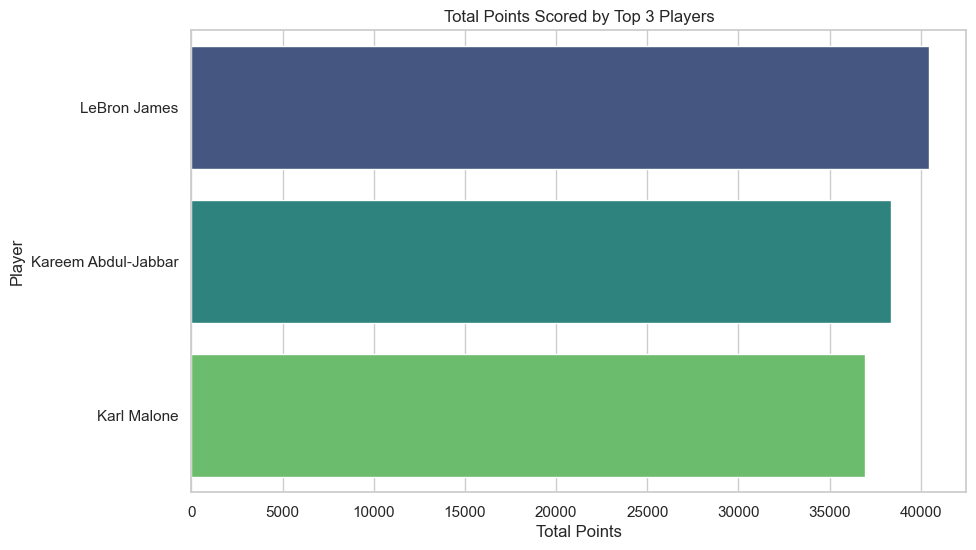

In [461]:
# Total Points Scored by Top 3 Players
plt.figure(figsize=(10, 6))
sns.barplot(x='Career_Points', y='Player', data=merged_df.sort_values(by='Career_Points', ascending=False), hue='Player', palette='viridis', dodge=False, legend=False)
plt.title('Total Points Scored by Top 3 Players')
plt.xlabel('Total Points')
plt.ylabel('Player')
plt.show()

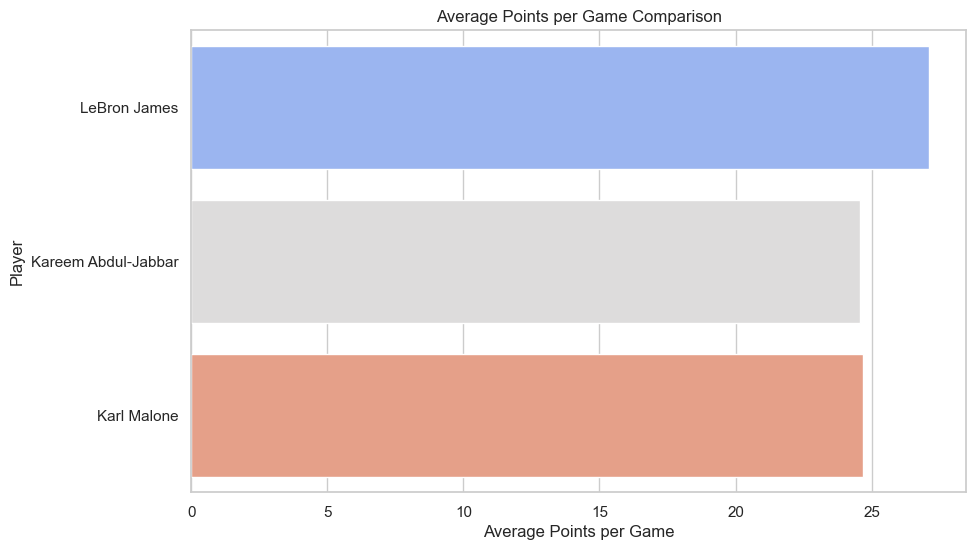

In [462]:
# Average Points per Game Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Average Points per Game', y='Player', data=df_comparison, hue='Player', palette='coolwarm', legend=False)
plt.title('Average Points per Game Comparison')
plt.xlabel('Average Points per Game')
plt.ylabel('Player')
plt.show()

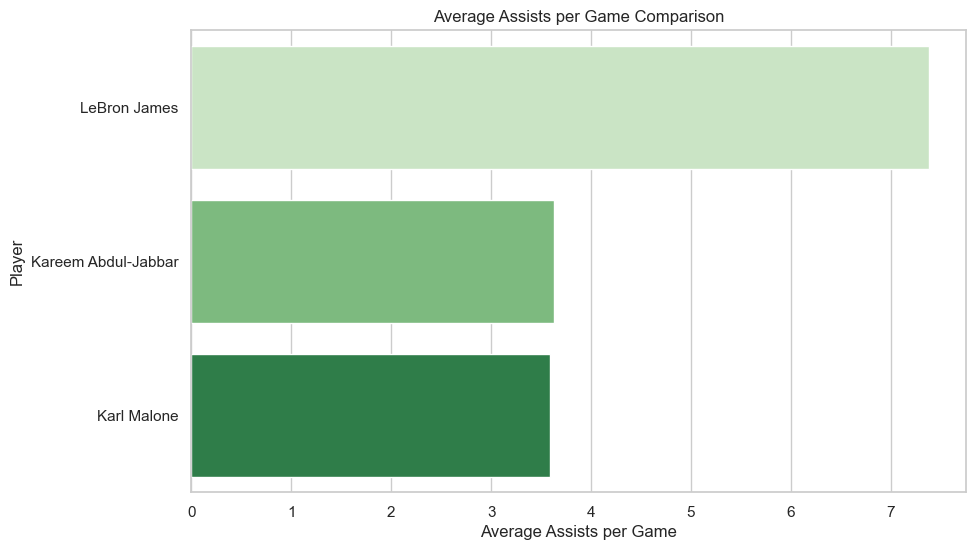

In [463]:
# Average Assists per Game Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Average Assists per Game', y='Player', data=df_comparison, hue='Player', palette='Greens', dodge=False, legend=False)
plt.title('Average Assists per Game Comparison')
plt.xlabel('Average Assists per Game')
plt.ylabel('Player')
plt.show()

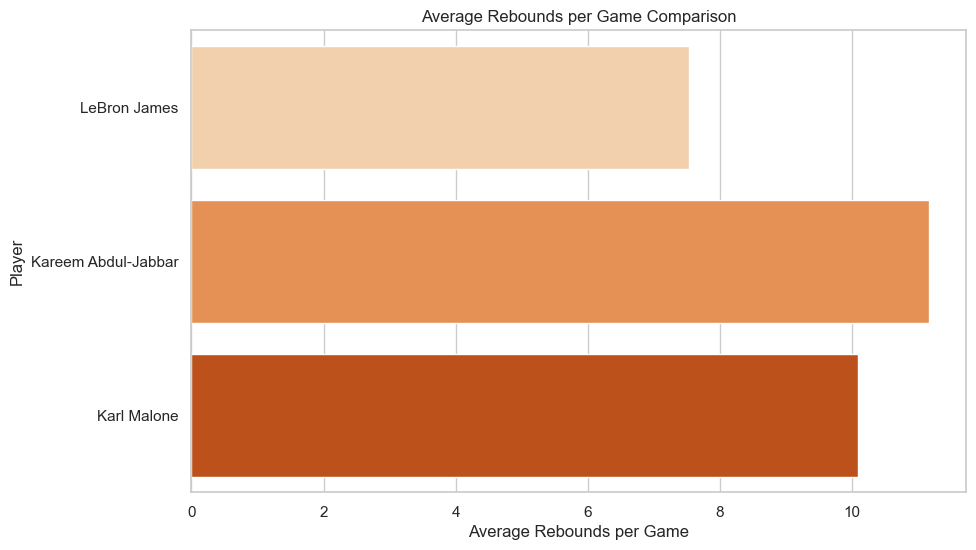

In [464]:
# Average Rebounds per Game
plt.figure(figsize=(10, 6))
sns.barplot(x='Average Rebounds per Game', y='Player', hue='Player', data=df_comparison, palette='Oranges', dodge=False, legend=False)
plt.title('Average Rebounds per Game Comparison')
plt.xlabel('Average Rebounds per Game')
plt.ylabel('Player')
plt.show()

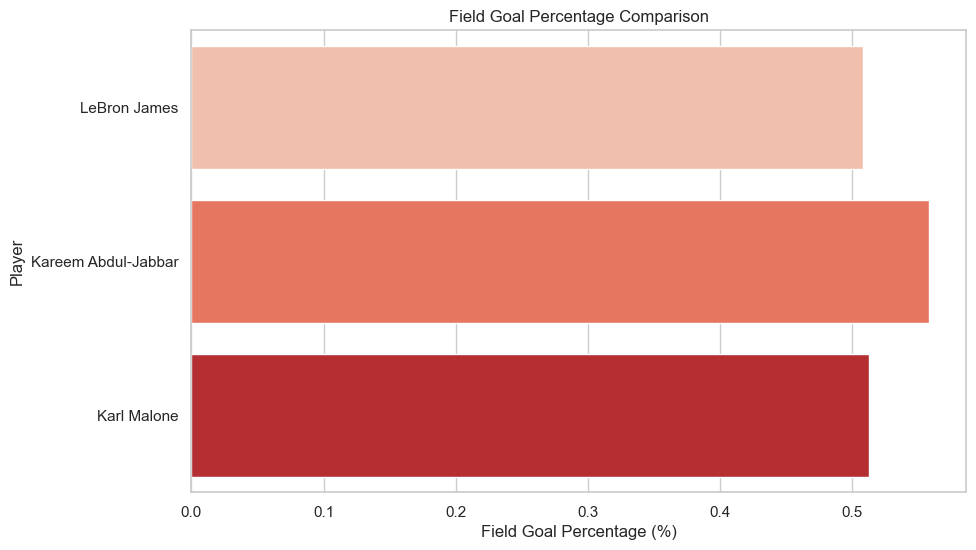

In [465]:
# Field Goal Percentage
plt.figure(figsize=(10, 6))
sns.barplot(x='Field Goal Percentage (%)', y='Player', hue='Player', data=df_comparison, palette='Reds', dodge=False, legend=False)
plt.title('Field Goal Percentage Comparison')
plt.xlabel('Field Goal Percentage (%)')
plt.ylabel('Player')
plt.show()

# Conclusion

##### In this exploratory analysis, we dove deep into the data of the NBA's all-time scoring leaders, focusing on LeBron James, Kareem Abdul-Jabbar, and Karl Malone. By combining historical statistics from Statista with additional scraped data from Basketball Reference, we aimed to understand not only their cumulative point totals but also their overall contributions across key metrics like assists, rebounds, and field goal efficiency.

**Key Insights:** 

1. ***Total Points Scored:*** LeBron James currently leads all-time, surpassing the career totals of Kareem Abdul-Jabbar and Karl Malone. This achievement places him in an exclusive tier of prolific scorers whose career longevity and consistent output stand out.
2. ***Points per Game:*** When analyzing average points per game, LeBron James maintained a remarkable scoring pace over his career, slightly edging out the others. However, the differences in their roles and styles of play reflect different paths to greatness, from LeBron's versatile scoring to Kareem’s unmatched skyhook efficiency.
3. ***Assist and Rebound Contributions:*** LeBron James also demonstrated his versatility by contributing more in assists compared to the other two legends, highlighting his playmaking abilities. On the other hand, Karl Malone was notable for his high rebounding averages, showcasing his dominance in securing possessions and making an impact in the paint.
4. ***Efficiency:*** In terms of shooting efficiency, Kareem Abdul-Jabbar had the highest field goal percentage, benefiting from his effective use of close-range shots like the skyhook. LeBron and Malone also exhibited strong shooting efficiencies, which have contributed significantly to their ability to sustain high scoring outputs over their careers.

**Overall Impact and Takeaways:**

##### This analysis illustrates the diversity in styles among the top three NBA scorers. Kareem Abdul-Jabbar's scoring was driven by a blend of consistent efficiency and iconic moves like the skyhook, while Karl Malone leveraged his power and presence in the paint. LeBron James, with his all-around game, showcased the evolution of the NBA star into a multidimensional player, capable of leading in scoring while also excelling in facilitating plays and rebounding.

##### The data also reveals how their contributions go beyond the scoring column, highlighting the importance of versatility in maintaining a long and impactful career. As basketball continues to evolve, players like LeBron James set a new standard for what it means to be an all-time great — emphasizing not only scoring but also being an all-around team player.

##### By visualizing these insights, we see how different paths to greatness contribute to the legends of the game. The culmination of statistical dominance, playmaking, and scoring efficiency reflects not only individual talent but also adaptation to various roles throughout their careers. These trends provide valuable lessons for aspiring players: a high level of versatility, adaptability, and consistency is key to becoming a true all-time NBA great.

##### In conclusion, while all three players have etched their names in the history books through their incredible scoring records, their career achievements also show us the different dimensions of success in professional basketball — from being a scoring machine to mastering efficiency and impacting the game in multiple ways.